In [1]:
import torch
import random
from transformer_lens import HookedTransformer, HookedTransformerConfig 
import pickle
from dataclasses import asdict
import circuitsvis as cv
import matplotlib.pyplot as plt
import numpy as np
from fancy_einsum import einsum

/home/jacob/anaconda3/envs/interp2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
str2int = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    ' ' : 10,
    '\n' : 11,
    '>' : 12,
    '=' : 13,
    '[' : 14,
    ']' : 15
}
int2str = {v: k for k, v in str2int.items()}
int2str[11] = '\\n'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def gen_list(n, without_rep=True):
    if without_rep:
        return random.sample(range(10), n)
    else:
        return [random.randint(0, 9) for _ in range(n)]

def gen_ex():
    a = gen_list(3)
    idx = random.randint(0, 2)

    y = random.randint(0, 9)
    while y in a:
        y = random.randint(0, 9)

    template = '''{}
[{}]={}
>{}'''

    b = a.copy()
    b[idx] = y

    return template.format("".join(map(str, a)), idx, y, "".join(map(str, b)))

def str_to_tokens(ex):
    return [str2int[c] for c in ex]

def tokens_to_str(tokens):
    return "".join([int2str[t] for t in tokens])


In [3]:
def load_model(pth):
    with open(pth, 'rb') as f:
        obj = pickle.load(f)
        cfg = HookedTransformerConfig.from_dict(obj['cfg'])
        model = HookedTransformer(cfg)
        model.load_state_dict(obj['model'])
    return model

model = load_model('../models/model_1l_14.pkl')

In [4]:
def gen_viz():
    ex = gen_ex()
    tokens = torch.tensor(str_to_tokens(ex), dtype=torch.long).unsqueeze(0)
    logits, cache_model = model.run_with_cache(tokens, remove_batch_dim=True) 
    tokens_input = [int2str[t] for t in tokens.tolist()[0]]

    p0 = cache_model["pattern", 0, "attn"]
    return cv.attention.attention_patterns(tokens=tokens_input, attention=p0)


NOTES
The two different heads seems to be focused on two different algorithms. Head 0 assign greater weight to the postiion token (i in a\[i\]) and the value token for every token in the output. Except when the value token is the next to be output, then weight is only assigned to the value token.

Head 1 simply assign weight to the token from the orginal list before the modification.

In [5]:
gen_viz()

In [6]:
gen_viz()

In [7]:
gen_viz()

# generation

In [8]:
def gen_test_ex():
    a = gen_list(3)
    idx = random.randint(0, 2)

    y = random.randint(0, 9)
    while y in a:
        y = random.randint(0, 9)

    template = '''{}
[{}]={}
>'''

    b = a.copy()
    b[idx] = y

    return template.format("".join(map(str, a)), idx, y)

In [9]:
test_ex = gen_test_ex()

In [10]:
test_tokens = torch.tensor(str_to_tokens(test_ex), dtype=torch.long).unsqueeze(0)
test_tokens

tensor([[ 8,  0,  3, 11, 14,  2, 15, 13,  6, 11, 12]])

In [11]:
pred = model.generate(test_tokens, max_new_tokens=3, stop_at_eos=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 664.64it/s]


In [12]:
logits, cache_model = model.run_with_cache(pred.clone(), remove_batch_dim=True) 
tokens_input = [int2str[t] for t in pred.tolist()[0]]

In [13]:
tokens_input

['8', '0', '3', '\\n', '[', '2', ']', '=', '6', '\\n', '>', '8', '6', '6']

In [14]:
p0 = cache_model["pattern", 0, "attn"]
cv.attention.attention_patterns(tokens=tokens_input, attention=p0)

In [15]:
p0.shape

torch.Size([2, 14, 14])

MODEL embedding surgery

In [16]:
model2 = load_model('../models/model_1l_14.pkl')

In [17]:
model2.pos_embed.W_pos.shape

torch.Size([14, 128])

In [18]:
avg_vec = torch.mean(model2.pos_embed.W_pos, dim=0)

In [19]:
avg_embed = avg_vec.repeat((14, 1))

In [20]:
avg_embed.shape

torch.Size([14, 128])

In [21]:
zeros_embed = torch.zeros((14, 128), device="cuda")
zeros_embed.shape

torch.Size([14, 128])

In [22]:
enhanced_embed = model.pos_embed.W_pos * 5.0

In [23]:
model2.pos_embed.W_pos = torch.nn.Parameter(enhanced_embed)

In [24]:
ex = gen_ex()
tokens = torch.tensor(str_to_tokens(ex), dtype=torch.long).unsqueeze(0)

In [25]:
logits, cache_model = model2.run_with_cache(tokens, remove_batch_dim=True) 
tokens_input = [int2str[t] for t in tokens.tolist()[0]]
p0 = cache_model["pattern", 0, "attn"]
cv.attention.attention_patterns(tokens=tokens_input, attention=p0)

# importance of vectors

In [26]:
model_start = load_model('../models/model_1l_start.pkl')

In [27]:
model_start.embed.W_E.shape

torch.Size([16, 128])

In [28]:
diff = model.embed.W_E - model_start.embed.W_E

In [29]:
torch.mean(diff, dim=1)

tensor([ 0.0055,  0.0025, -0.0037, -0.0047, -0.0004, -0.0021, -0.0092, -0.0056,
         0.0048,  0.0035,  0.0000, -0.0030,  0.0008, -0.0026, -0.0029, -0.0030],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [30]:
str2int = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    ' ' : 10,
    '\n' : 11,
    '>' : 12,
    '=' : 13,
    '[' : 14,
    ']' : 15
}

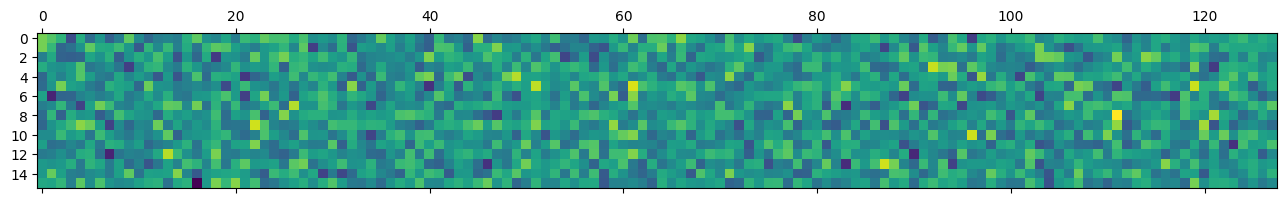

In [31]:
plt.matshow(model_start.embed.W_E.cpu().detach().numpy())

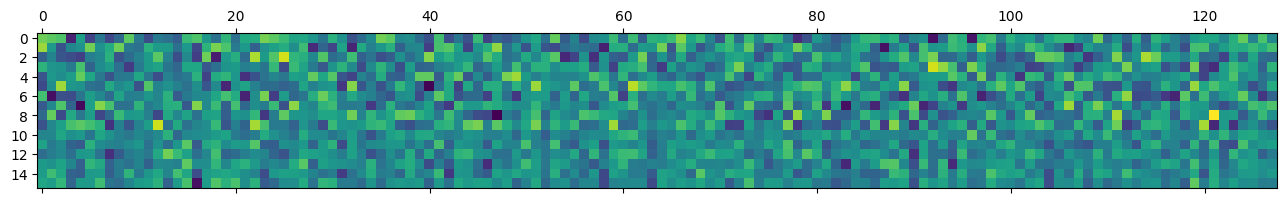

In [32]:
plt.matshow(model.embed.W_E.cpu().detach().numpy())

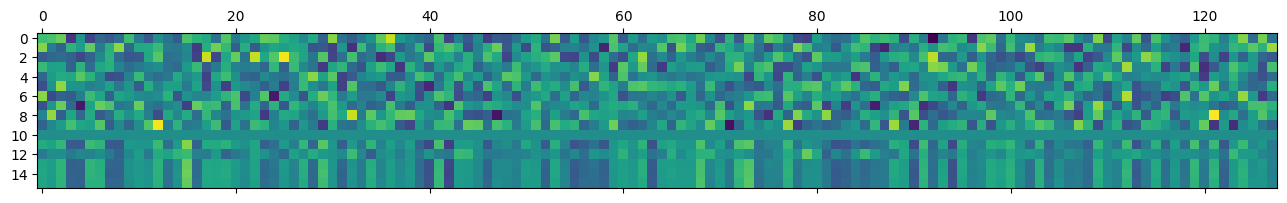

In [33]:
plt.matshow(diff.cpu().detach().numpy())

In [34]:
diff_cpu = diff.cpu().detach().numpy()

In [35]:
dist = [np.linalg.norm(x) for x in diff_cpu]

In [36]:
for i, v in enumerate(dist):
    print(int2str[i], v)

0 0.8511477
1 0.8465336
2 0.84315574
3 0.7530479
4 0.664922
5 0.72169167
6 0.73525995
7 0.76639074
8 0.7544963
9 0.80024093
  0.0
\n 0.6561085
> 0.40985778
= 0.54012346
[ 0.5688056
] 0.5366082


In [37]:
# POS embedding

In [38]:
diff_pos = (model.pos_embed.W_pos - model_start.pos_embed.W_pos).cpu().detach().numpy()

In [39]:
dist_pos = [np.linalg.norm(x) for x in diff_pos]

In [40]:
ex

'104\n[0]=3\n>304'

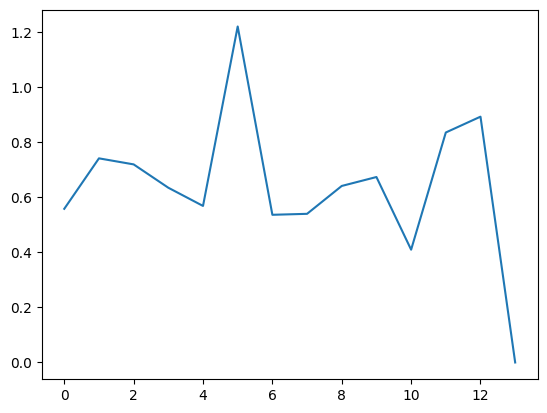

In [41]:
plt.plot(dist_pos)

In [42]:
tokens_input

['1', '0', '4', '\\n', '[', '0', ']', '=', '3', '\\n', '>', '3', '0', '4']

In [43]:
for i, v in enumerate(dist_pos):
    print(i+1, v)

1 0.558335
2 0.7416956
3 0.71975344
4 0.6349288
5 0.5688054
6 1.2208571
7 0.5366082
8 0.54012305
9 0.64141643
10 0.6738527
11 0.409857
12 0.8356515
13 0.8931526
14 0.0


# copying behaviour of OV circuit

The behaviour of the QK has been explore. Lets explore the OV circuit

In [44]:
model.blocks[0].attn

Attention(
  (hook_k): HookPoint()
  (hook_q): HookPoint()
  (hook_v): HookPoint()
  (hook_z): HookPoint()
  (hook_attn_scores): HookPoint()
  (hook_pattern): HookPoint()
  (hook_result): HookPoint()
)

In [65]:
all_token_embeddings = model.embed(range(10))

In [66]:
all_token_embeddings.shape

torch.Size([10, 128])

In [67]:
pos = 1
token_embeddings_at_pos = all_token_embeddings + model.pos_embed(all_token_embeddings)[:,pos,:] if pos > -1 else all_token_embeddings

In [78]:
token_embeddings_at_pos.shape

torch.Size([10, 128])

In [68]:
attn = model.blocks[0].attn

In [79]:
attn.W_V.shape

torch.Size([2, 128, 64])

In [85]:
embeddings_value = einsum("n_ctx d_model, n_heads d_model d_head -> n_heads n_ctx d_head", 
                       token_embeddings_at_pos, attn.W_V)

embeddings_out = einsum("n_heads n_ctx d_head, n_heads d_head d_model -> n_heads n_ctx d_model",
                    embeddings_value, attn.W_O)

In [83]:
attn.W_O.shape

torch.Size([2, 64, 128])

In [82]:
embeddings_value.shape

torch.Size([2, 10, 64])

In [87]:
embeddings_out.shape

torch.Size([2, 10, 128])

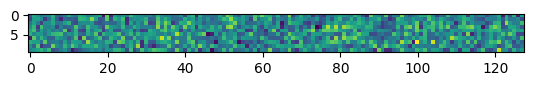

In [90]:
plt.imshow(embeddings_out[0].cpu().detach().numpy())

In [94]:
model.unembed.W_U.shape

torch.Size([128, 16])

In [97]:
embedded_toks = einsum(
    "n_heads pos d_model, d_model n_vocab -> n_heads pos n_vocab",
    embeddings_out,
    model.unembed.W_U
)

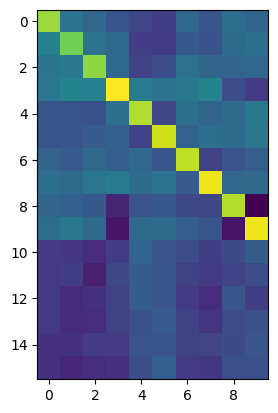

In [105]:
plt.imshow(embedded_toks[0].T.cpu().detach().numpy())

In [70]:
ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach().cpu()

In [91]:
ov_circuit_attn_heatmap.shape

torch.Size([2, 10, 16])

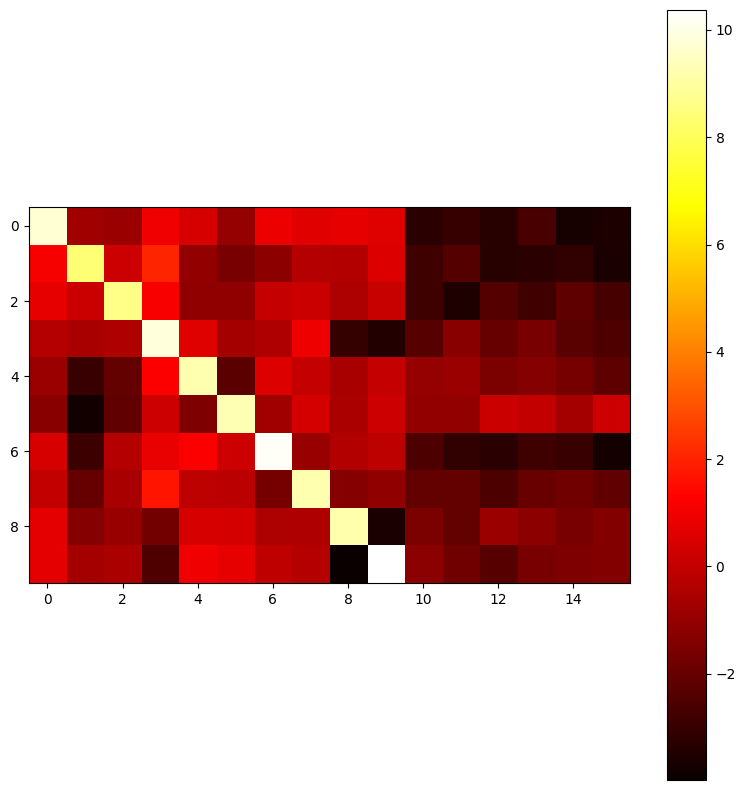

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(ov_circuit_attn_heatmap[1], cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

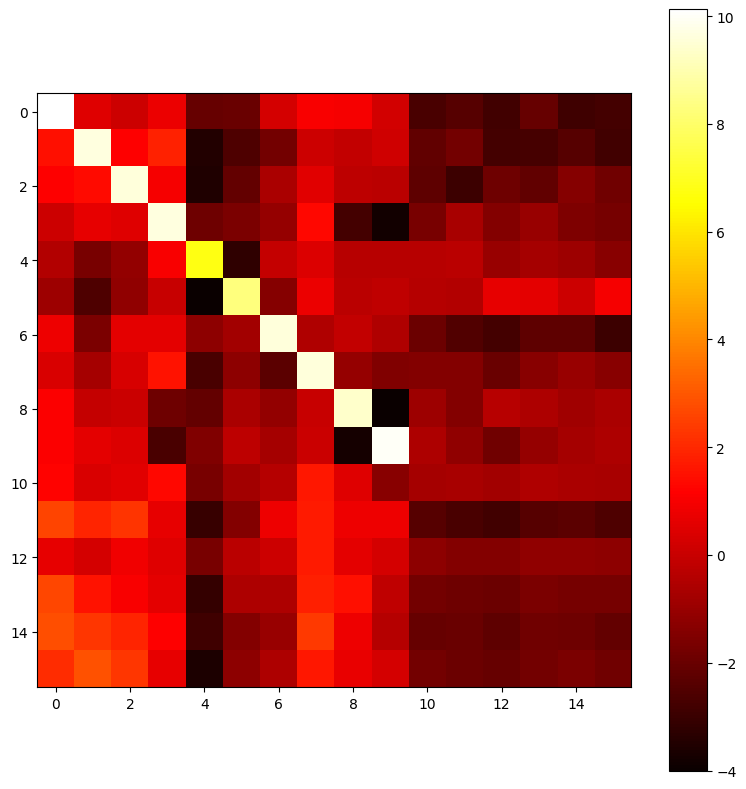

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(ov_circuit_attn_heatmap[1], cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

In [53]:
def copying_score():
    ov_circuit = model.embed.W_E @ model.OV @ model.unembed.W_U
    eigenvalues  = ov_circuit.eigenvalues
    copy_score = eigenvalues.sum(dim=-1).real / eigenvalues.abs().sum(dim=-1)
    return copy_score.detach()

In [54]:
circuit = model.embed.W_E @ model.OV@model.unembed.W_U

In [55]:
copying_score()

tensor([[0.9447, 0.9405]], device='cuda:0')

In [56]:
# QK circuit

In [72]:
ex = gen_ex()

In [73]:
ex

'218\n[2]=6\n>216'

In [75]:
toks = str_to_tokens(ex)[:10]

In [107]:
toks

[2, 1, 8, 11, 14, 2, 15, 13, 6, 11]

In [76]:
tokens = torch.tensor(toks, dtype=torch.long).unsqueeze(0)
logits, cache_model = model.run_with_cache(tokens, remove_batch_dim=True) 
tokens_input = [int2str[t] for t in tokens.tolist()[0]]

p0 = cache_model["pattern", 0, "attn"]

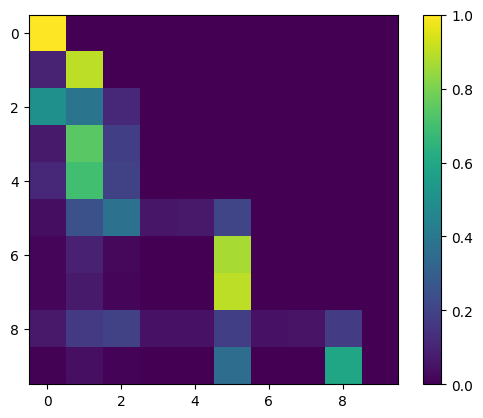

In [77]:
g = plt.imshow(p0[0].detach().cpu(), interpolation="nearest")
plt.colorbar(g)

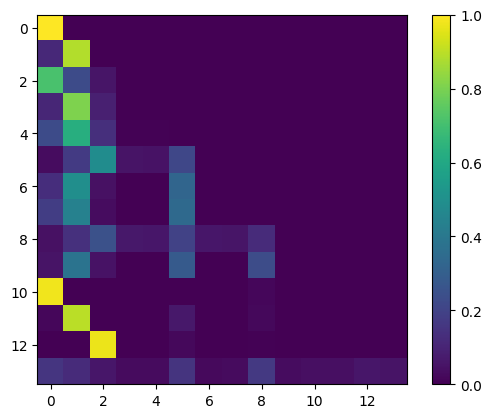

In [59]:
g = plt.imshow(p0[1].detach().cpu(), interpolation="nearest")
plt.colorbar(g)